# SMC Diagnostics  

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats
import pytensor.tensor as pt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use('arviz-white')

## N-Dimensional Gaussian

First trial for a set with different N of dimensions (20, 40, 60, 80, 100), for a single N-Dimensional Gaussian distribution

In [3]:
dims = range(20, 110, 20)

stdev = 0.1

In [4]:
def ndim_gaussian(x):
    log_like1 = - 0.5 * n * pt.log(2 * np.pi) \
                - 0.5 * logdsigma \
                - 0.5 * (x - mu).T.dot(isigma).dot(x - mu)
    
    return pm.math.logsumexp([log_like1])

In [5]:
idatas_gauss = {
    "20": {}, "40": {}, "60": {},
    "80": {}, "100": {},
}

In [6]:
for n in dims:
    mu = np.ones(n) * (1. / 2) #media 0.5
    sigma = np.power(stdev, 2) * np.eye(n) 
    isigma = np.linalg.inv(sigma)
    logdsigma = np.linalg.slogdet(sigma)[1]
    
    # Model
    with pm.Model() as gaussian:
        X = pm.Uniform('X',
                       shape=n,
                       lower=-2. * np.ones_like(mu),
                       upper=2. * np.ones_like(mu),
                       initval=-1. * np.ones_like(mu))
        llk = pm.Potential('llk', ndim_gaussian(X))

        idata = pm.sample_smc(5000, chains=4)
        idatas_gauss[str(n)] = idata

Initializing SMC sampler...
Sampling 4 chains in 3 jobs


Initializing SMC sampler...
Sampling 4 chains in 3 jobs


Initializing SMC sampler...
Sampling 4 chains in 3 jobs


Initializing SMC sampler...
Sampling 4 chains in 3 jobs


Initializing SMC sampler...
Sampling 4 chains in 3 jobs


In [7]:
for n in dims:
    cov_test = idatas_gauss[f'{n}'].sample_stats.cov
    print(f'{n}', np.shape(cov_test))# Errors in shapes

20 (4, 18, 20, 20)
40 (4, 26, 40, 40)
60 (1, 4)
80 (4, 38, 80, 80)
100 (1, 4)


0.49987688019038673
0.5002086464360194
0.5001333481302911
0.5000795623497962
0.49998811479964145


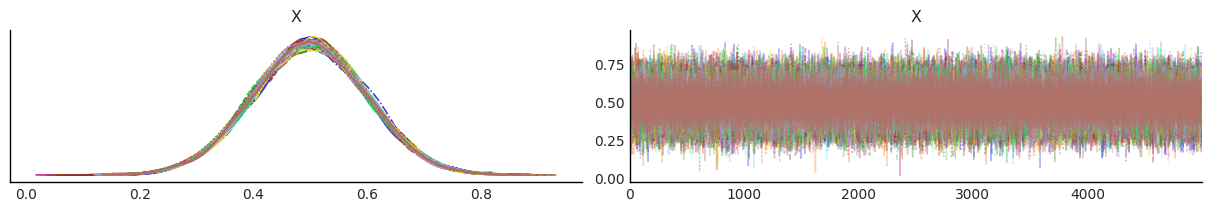

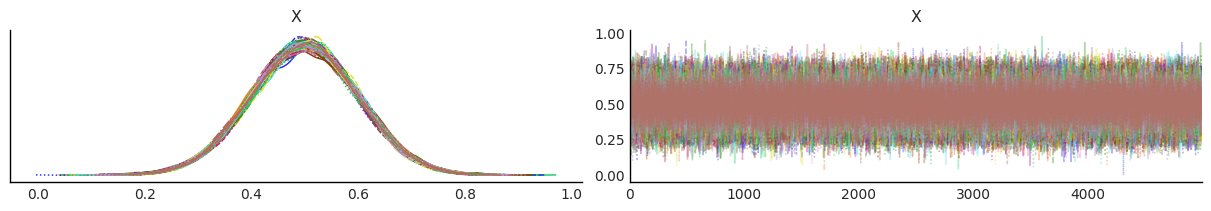

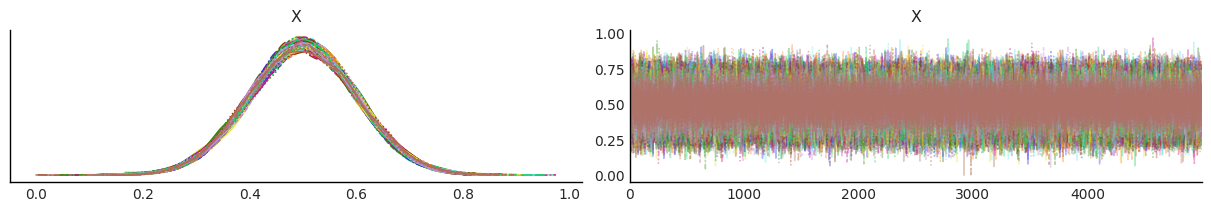

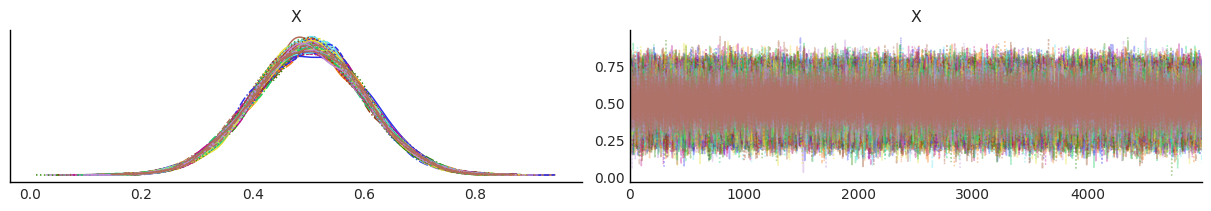

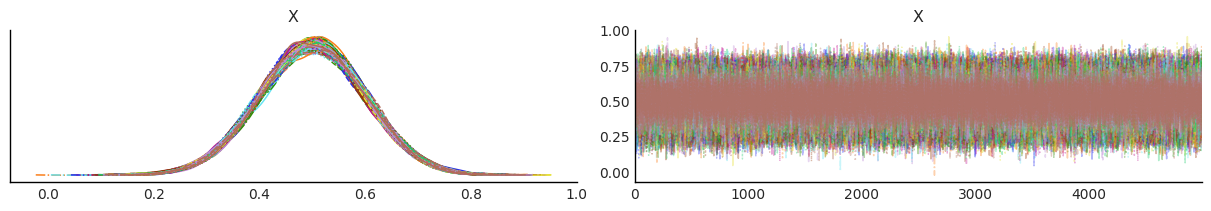

In [9]:
for n in dims:
    idata = idatas_gauss[str(n)]
    ax = az.plot_trace(idata, compact=True)
    #ax[0, 0].axvline(-0.5, 0, .9, color="k")
    #ax[0, 0].axvline(0.5, 0, 0.1, color="k")
    #ax[0, 0].set_xlim(-1, 1)
    print(np.mean(idata.posterior["X"]).item())

1.0
0.99999875
0.9999991666666667
1.0
0.9999995


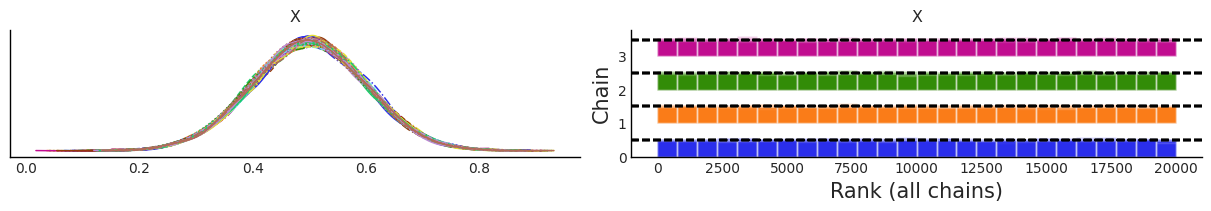

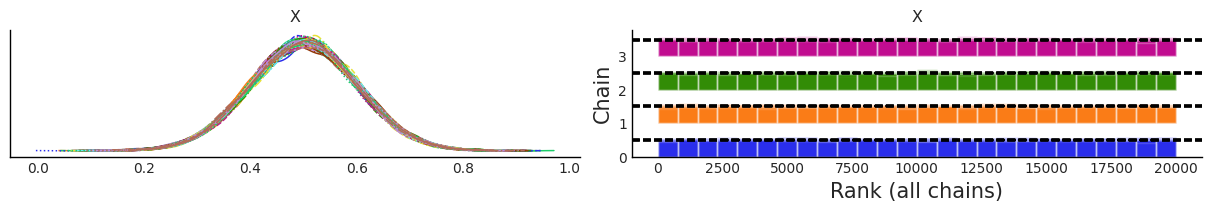

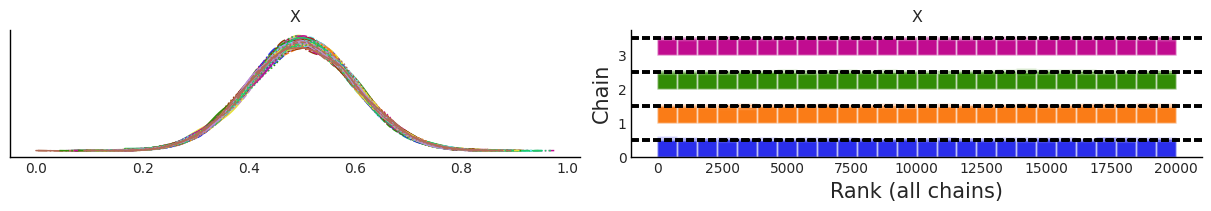

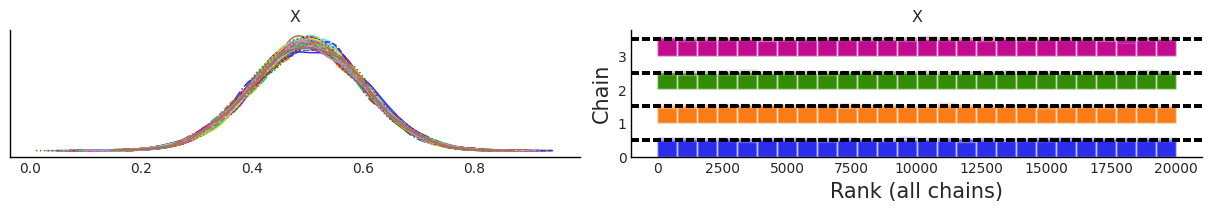

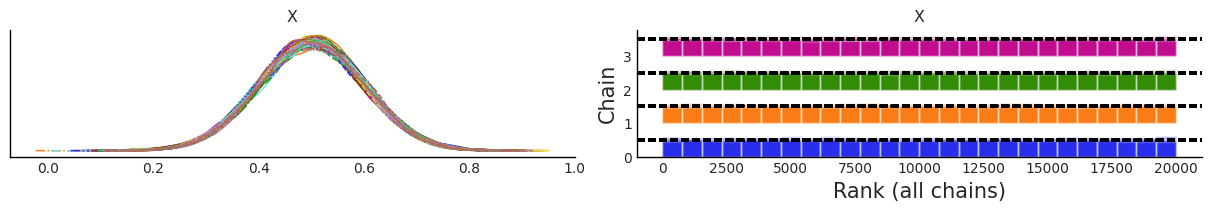

In [10]:
for n in dims:
    idata = idatas_gauss[str(n)]
    ax = az.plot_trace(idata, compact=True, kind="rank_bars")
    #ax[0, 0].axvline(-0.5, 0, .9, color="k")
    #ax[0, 0].axvline(0.5, 0, 0.1, color="k")
    #ax[0, 0].set_xlim(-1, 1)
    print(np.mean(idata.posterior["X"] > 0).item())

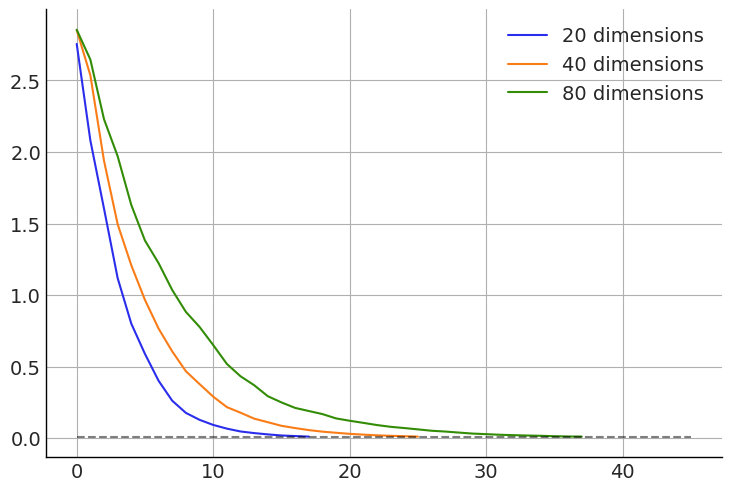

In [13]:
for n in [20, 40, 80]:# Probar esas dimensiones XXX
    covariance_matrix = idatas_gauss[str(n)].sample_stats.cov
    beta_stages = np.shape(covariance_matrix)[1]
    x = [beta for beta in range(0,beta_stages)]
    y = [float(covariance_matrix[0][beta][0][0]) for beta in range(0,beta_stages)]
    plt.plot(x,y,label=f'{n} dimensions')
    plt.legend()
    plt.grid(True)
plt.hlines(stdev**2, 0, 45, color="black", linestyles="--", alpha=0.5);

In [17]:
#Wasserstein distance XXX CHECK THIS LATER XXX

def wasserstein_distance(idata, plot=True):
    """
    Compute wasserstein distance
    """
    
    # extract posterior, number of samples and dimensions
    x_posterior = idata.posterior["X"].stack(samples=("chain", "draw"))
    n_samples = x_posterior.samples.size
    dims = x_posterior.X_dim_0.size
    
    # evaluate (e)cdf at this points
    x = np.linspace(-1, 1, n_samples)

    # compute ecdf for each posterior marginal
    ecdf_obs = np.empty((n_samples, dims))
    for dim in x_posterior.coords["X_dim_0"]:
        values = np.sort(x_posterior.sel(X_dim_0=dim))
        ecdf_obs[:,dim] = np.searchsorted(values, x) / n_samples

    # compute the expected cdf
    ecdf_exp = stats.norm(mu[0], stdev).cdf(x)

    wsd = np.mean(np.mean((ecdf_obs.T - ecdf_exp)**2, axis=1)**0.5)
    
    if plot:
        _, ax = plt.subplots()
        ax.plot(x, ecdf_exp, "k", label="expected")
        ax.plot(x, ecdf_obs, "C1")
        ax.plot(0, 0, "C1",  label="observed")
        ax.legend()
        ax.set_title(f"Wasserstein distance ={wsd:.4f}")
    return wsd

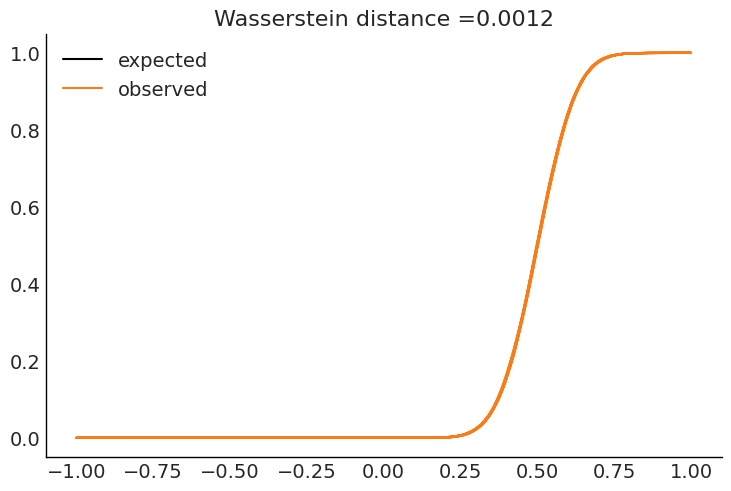

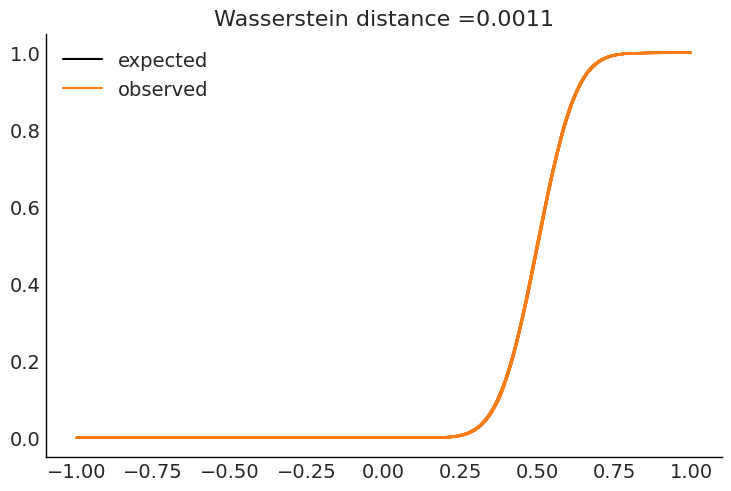

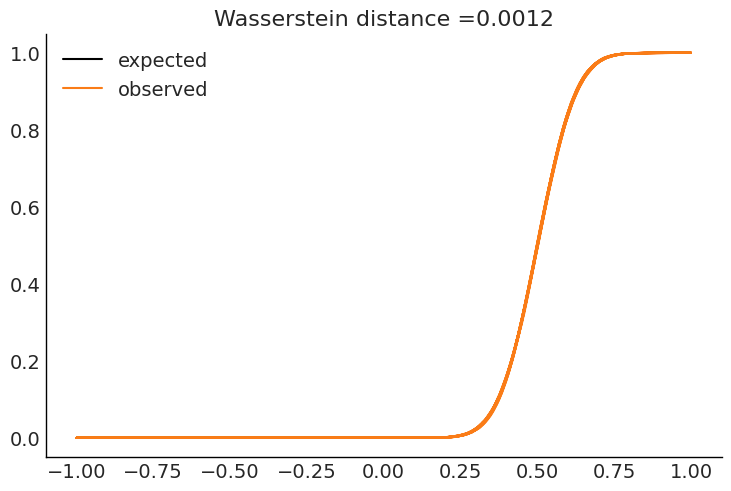

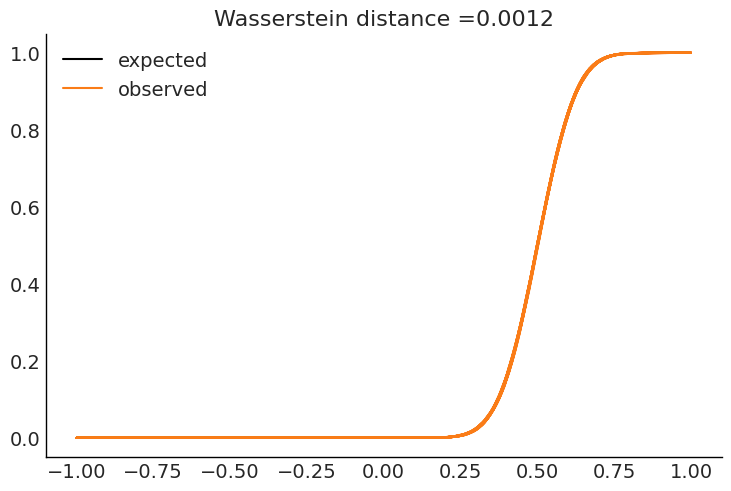

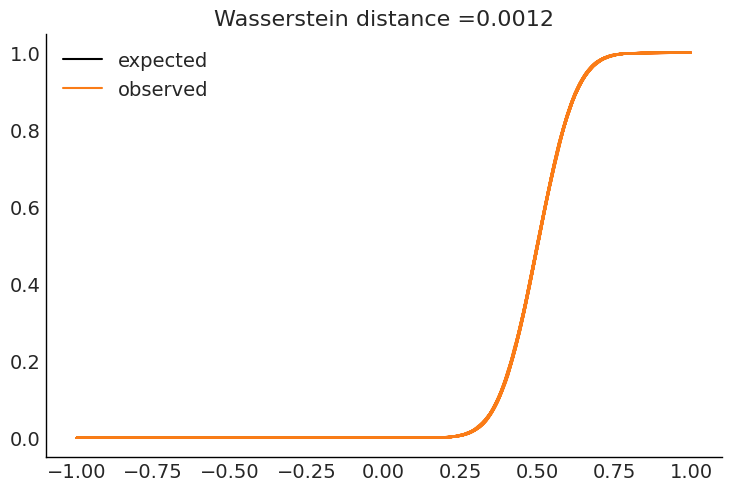

In [18]:
for n in dims:
    idata = idatas_gauss[str(n)]
    wasserstein_distance(idata)